In [1]:
import numpy as np
import pandas as pd
from osgeo import gdal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import earthpy.plot as ep
import earthpy as et
from matplotlib.colors import ListedColormap
import earthpy.spatial as es
import earthpy.plot as ep
from pyrsgis import raster

### Open the GeoTIFF files using GDAL

In [2]:
# Open the GeoTIFF files using GDAL
datasetTrainingGT = gdal.Open(r"C:\Users\MONSTER\Downloads\S2A_MSIL1C_20220516_Train_GT.tif")

# Read the data from the first GeoTIFF file into a NumPy array
trainGT2d = datasetTrainingGT.ReadAsArray()
trainGT2d = np.swapaxes(trainGT2d, 0, 1)
# Convert the 2-dimensional NumPy arrays into 2-dimensional arrays with rows and columns
trainGT1d = trainGT2d.reshape(trainGT2d.shape[0] * trainGT2d.shape[1], 1)

# Convert the combined array into a Pandas DataFrame
dfTrainLabels = pd.DataFrame(trainGT1d)

# Export the DataFrame as a CSV file
# dfTrainLabels.to_csv('train.csv', index=False)


In [3]:
datasetTraining = gdal.Open(r"C:\Users\MONSTER\Downloads\S2A_MSIL1C_20220516_TrainingData.tif")


# Read the data from the first GeoTIFF file into a NumPy array
dataTraing = datasetTraining.ReadAsArray()
dataTraing = np.swapaxes(dataTraing, 0, 2)
# Convert the 2-dimensional NumPy arrays into 2-dimensional arrays with rows and columns
dataTraining1d = dataTraing.reshape(dataTraing.shape[0] * dataTraing.shape[1], -1)
dfTrain = pd.DataFrame(dataTraining1d)

final_data = pd.concat([dfTrainLabels, dfTrain])

train_label_data = pd.concat([dfTrainLabels, dfTrain], axis=1)
train_label_data.columns=['Code', 'Blue', 'Green', 'Red', 'NIR']
train_label_data.to_csv('train.csv')

In [5]:
datasetTest = gdal.Open(r"C:\Users\MONSTER\Downloads\S2B_MSIL1C_20220528_Test.tif")

# Read the data from the first GeoTIFF file into a NumPy array
dataTest2d = datasetTest.ReadAsArray()
dataTest2d = np.swapaxes(dataTest2d, 0, 2)
# Convert the 2-dimensional NumPy arrays into 2-dimensional arrays with rows and columns
dataTest1d = dataTest2d.reshape(dataTest2d.shape[0] * dataTest2d.shape[1], -1)
np.save('test_all.npy', dataTest1d)
# Convert the combined array into a Pandas DataFrame
dfTest = pd.DataFrame(dataTest1d)
dfTest.columns=['Blue', 'Green', 'Red', 'NIR']
# Export the DataFrame as a CSV file
dfTest.to_csv('test.csv')

## Visualize Data

In [6]:
label = ("S2A_MSIL1C_20220516_Train_GT.tif")
data =("S2A_MSIL1C_20220516_TrainingData.tif")

In [7]:
ds1, featuresTrain = raster.read(data, bands='all')
ds2, featuresTest = raster.read(label, bands ='all')

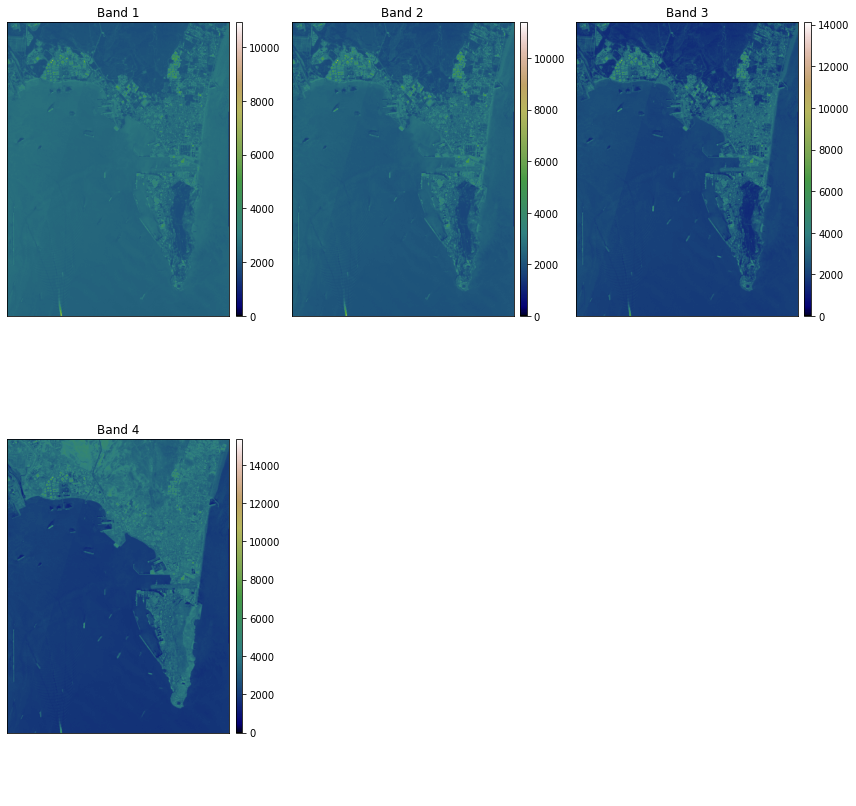

array([[<Axes: title={'center': 'Band 1'}>,
        <Axes: title={'center': 'Band 2'}>,
        <Axes: title={'center': 'Band 3'}>],
       [<Axes: title={'center': 'Band 4'}>, <Axes: >, <Axes: >]],
      dtype=object)

In [8]:
#Plotting each bands
ep.plot_bands(featuresTrain,cmap='gist_earth')

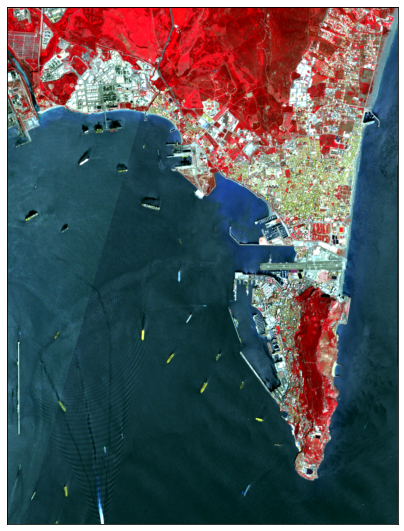

In [9]:
rgb = ep.plot_rgb(featuresTrain,rgb=(3,2,1),stretch=True,figsize=(7,10))

plt.show()

## Data Distribution of Bands

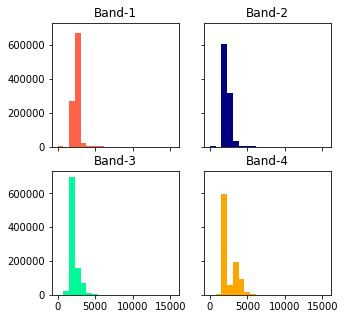

In [10]:
colors = ['tomato', 'navy', 'MediumSpringGreen', 'orange']
ep.hist(featuresTrain,colors=colors,title=[f'Band-{i}' for i in range(1, 5)],figsize=(5,5))
plt.show()
     

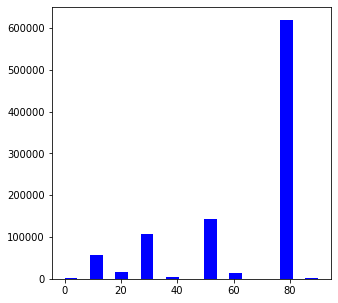

In [11]:

ep.hist(featuresTest,colors='blue',figsize=(5,5))
plt.show()

## Normalized Difference Vegetation Index (NDVI)

NDVI = ((NIR - Red)/(NIR + Red))

NIR = pixel values from the near-infrared band

Red = pixel values from the red band

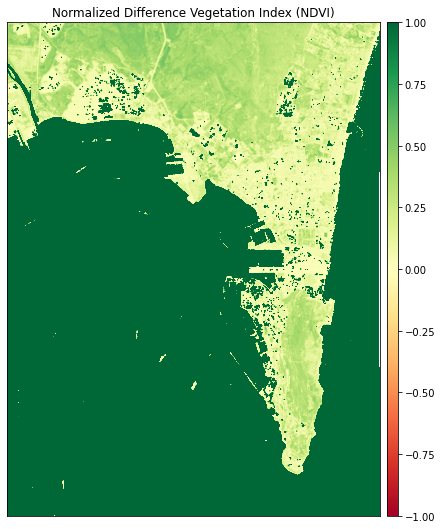

In [12]:
ndvi = (featuresTrain[3]- featuresTrain[2])/(featuresTrain[3]+ featuresTrain[2])

titles = ["Normalized Difference Vegetation Index (NDVI)"]
ep.plot_bands(ndvi, cmap="RdYlGn", cols=1,title=titles, vmin=-1, vmax=1, figsize=(7, 10))

plt.show()

# Classification Model

In [29]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [30]:
train.head()

,Unnamed: 0,Code,Blue,Green,Red,NIR
0,0,10,0,0,0,0
1,1,10,1997,1982,1860,3672
2,2,10,1950,1906,1776,3335
3,3,10,1933,1886,1742,3390
4,4,10,2162,2035,2173,3605


In [31]:
test.head()

,Unnamed: 0,Blue,Green,Red,NIR
0,0,0,0,0,0
1,1,1938,1880,1683,3362
2,2,1943,1874,1661,3388
3,3,1959,1876,1690,3354
4,4,1943,1873,1696,3305


In [32]:

train = train[train.Code != 0]

In [33]:
train.drop("Unnamed: 0", axis=1, inplace=True)
test.drop("Unnamed: 0", axis=1, inplace=True)

In [34]:
### Scale Data-not used 
#creates a new DataFrame named scaled_train by fitting and transforming the train data using MinMaxScaler(). 
#The resulting data is scaled between 0 and 1.

scaled_train = pd.DataFrame(MinMaxScaler().fit_transform(train), columns=train.columns)
scaled_test =  pd.DataFrame(MinMaxScaler().fit_transform(test), columns=test.columns)

In [35]:
data = np.array(train.drop("Code", axis=1)[::10])

data1d = np.array(train["Code"][::10])

### Split data

In [36]:
X_train, X_test, y_train, y_test = train_test_split(data, data1d, test_size = 0.3)

## Classification Methods

## 1-k-NN

In [71]:
from sklearn.neighbors import KNeighborsClassifier

k=5
knn = KNeighborsClassifier(n_neighbors=k)

# Fit
knn.fit(X_train, y_train)

#Predict

knn_pred = knn.predict(X_test)

In [72]:
accuracy_knn = accuracy_score(y_test, knn_pred)

In [73]:
print('Accuracy : {}'.format(accuracy_score(y_test,knn_pred)*100))

Accuracy : 89.33305716652859


In [74]:
labels = ['Tree cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up', 'Bare/sparse vegetation', 'Snow and ice','Permanent water bodies']
print(classification_report(y_test, knn_pred, target_names=labels))

                        precision    recall  f1-score   support

            Tree cover       0.67      0.63      0.65      1720
             Shrubland       0.55      0.49      0.52       491
             Grassland       0.67      0.73      0.70      3241
              Cropland       0.33      0.12      0.18       136
              Built-up       0.80      0.85      0.82      4238
Bare/sparse vegetation       0.51      0.25      0.34       431
          Snow and ice       0.99      0.99      0.99     18652
Permanent water bodies       0.26      0.08      0.13        59

              accuracy                           0.89     28968
             macro avg       0.60      0.52      0.54     28968
          weighted avg       0.89      0.89      0.89     28968



In [75]:
y_pred_KNN = knn.predict(test)

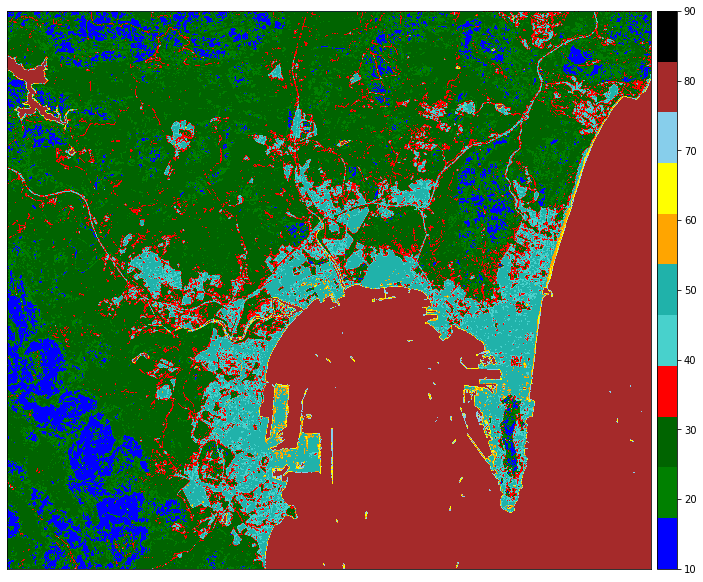

<Axes: >

In [76]:
ep.plot_bands(y_pred_KNN.reshape(2309, 2001).T,cmap=ListedColormap(['blue', 'green', 'darkgreen','red','MediumTurquoise','LightSeaGreen','orange','yellow','SkyBlue','brown','black']))

## KNN parameter

In [77]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
import statistics

In [78]:
# Stratified K-fold Cross Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import statistics

X=data
y=data1d

kfold = 10
skfolds = StratifiedKFold(n_splits=kfold)

scores = [];
for train_index, test_index in skfolds.split(X,y):
    clone_knn = clone(knn)
    X_train_folds = X[train_index]
    y_train_folds = y[train_index]
    X_test_fold = X[test_index]
    y_test_fold = y[test_index]

    clone_knn.fit(X_train_folds, y_train_folds)
    y_pred = clone_knn.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    knnScore = n_correct / len(y_pred);
    scores.append(knnScore)
    print('KNN score for a fold = ', knnScore)

print('')
print('Average accuracy in ', kfold, '- fold cross-validation for KNN with K=', k, ' is ', statistics.mean(scores))    

KNN score for a fold =  0.8605012427506213
KNN score for a fold =  0.9222245236122618
KNN score for a fold =  0.897887323943662
KNN score for a fold =  0.899751449875725
KNN score for a fold =  0.8957125103562552
KNN score for a fold =  0.8777961888980944
KNN score for a fold =  0.8707539353769677
KNN score for a fold =  0.8741714995857498
KNN score for a fold =  0.8836992543496272
KNN score for a fold =  0.8607975142413258

Average accuracy in  10 - fold cross-validation for KNN with K= 5  is  0.884329544299029


In [79]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(knn, X, y, cv=kfold, scoring="accuracy")
print('Average accuracy in ', kfold, '- fold cross-validation for KNN with K=', k, ' is ', statistics.mean(scores))
scores

Average accuracy in  10 - fold cross-validation for KNN with K= 5  is  0.884329544299029


array([0.86050124, 0.92222452, 0.89788732, 0.89975145, 0.89571251,
       0.87779619, 0.87075394, 0.8741715 , 0.88369925, 0.86079751])

Average accuracy in  10 - fold cross-validation for KNN with K= 1  is  0.8599610667017917
Average accuracy in  10 - fold cross-validation for KNN with K= 3  is  0.8751434547823695
Average accuracy in  10 - fold cross-validation for KNN with K= 5  is  0.884329544299029
Average accuracy in  10 - fold cross-validation for KNN with K= 7  is  0.8889899191965391
Average accuracy in  10 - fold cross-validation for KNN with K= 9  is  0.8905537040747546
Average accuracy in  10 - fold cross-validation for KNN with K= 11  is  0.8918586222608751
Average accuracy in  10 - fold cross-validation for KNN with K= 13  is  0.891765444925317
Average accuracy in  10 - fold cross-validation for KNN with K= 15  is  0.8919207973340393
Average accuracy in  10 - fold cross-validation for KNN with K= 17  is  0.8926561064685244
Average accuracy in  10 - fold cross-validation for KNN with K= 19  is  0.8927389479288992
Average accuracy in  10 - fold cross-validation for KNN with K= 21  is  0.8923971743459201
Averag

Text(0.5, 1.0, 'K-fold Cross Validation, Test Accuracies with respect to k (for k-NN)')

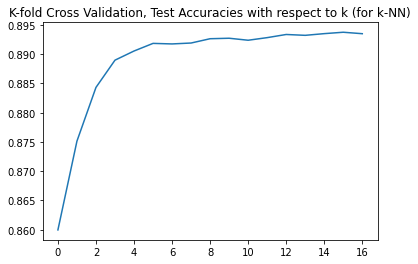

In [80]:
scores = [];

bestScore = 0;
bestK = 0;
for k in range(1, 35, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knnScores = cross_val_score(knn, X, y, cv=kfold, scoring="accuracy")
    knnScore = statistics.mean(knnScores);
    scores.append(knnScore);
    
    print('Average accuracy in ', kfold, '- fold cross-validation for KNN with K=', k, ' is ', knnScore)
    if (knnScore > bestScore):
        bestScore = knnScore;
        bestK = k

print('')
print('Best K is ', bestK, ' with best score as ', bestScore)

plt.plot(scores)
plt.title('K-fold Cross Validation, Test Accuracies with respect to k (for k-NN)')

### Performance for best k

In [82]:
# performance for best K
knn = KNeighborsClassifier(n_neighbors=bestK)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=123)

knn.fit(X_train, y_train)

y_train_pred = knn.predict(X_train)
print("Training accuracy = ", sum(y_train_pred == y_train) / len(y_train_pred))

y_test_pred = knn.predict(X_test)
print("Test accuracy = ", sum(y_test_pred == y_test) / len(y_test_pred))

confusion_matrix(y_test, y_test_pred)

Training accuracy =  0.9017792414921602
Test accuracy =  0.896996685998343


array([[ 1710,   167,   905,     0,   105,     1,     5,     2],
       [  253,   364,   151,     0,     1,     0,     1,     0],
       [  331,   138,  4145,     8,   770,    11,     4,     5],
       [    0,     0,   148,    12,    49,     3,     1,     0],
       [   10,     3,   707,     9,  6311,    39,    85,     0],
       [    1,     0,    53,     1,   518,   155,    38,     0],
       [    2,     1,     9,     0,   312,    47, 30608,     1],
       [   14,     3,    25,     0,    34,     0,     2,     2]],
      dtype=int64)

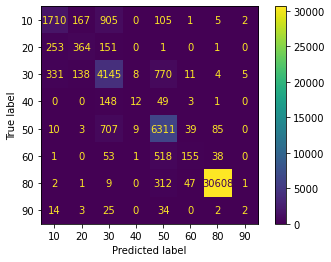

In [83]:
# Creating confusion matrix data
confusion_matrix_linear = confusion_matrix(y_test,y_test_pred)
#display
labels = ['10', '20', '30', '40', '50', '60', '80', '90']
cm_displayLinear = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_linear, display_labels=labels)

cm_displayLinear.plot()
plt.show()

## GridSearch with k-NN

In [86]:
cv_method = StratifiedKFold(n_splits=10,random_state=42,shuffle=True)

params_KNN = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7,8], 
               'p': [1, 2, 5]}

from sklearn.model_selection import GridSearchCV

gs_KNN = GridSearchCV(estimator=KNeighborsClassifier(), 
                      param_grid=params_KNN, 
                      cv=cv_method,
                      verbose=1,  # verbose: the higher, the more messages
                      scoring='accuracy', 
                      return_train_score=True)

gs_KNN.fit(X,y);
gs_KNN.best_params_
gs_KNN.best_score_
gs_KNN.cv_results_['mean_test_score']

Fitting 10 folds for each of 24 candidates, totalling 240 fits


array([0.86733501, 0.8677596 , 0.86720035, 0.86856743, 0.86846387,
       0.86826707, 0.88356343, 0.88318023, 0.8834495 , 0.88777845,
       0.88798558, 0.88816164, 0.89159996, 0.8914757 , 0.89146534,
       0.8933191 , 0.89349518, 0.89310163, 0.89535932, 0.89599106,
       0.89529718, 0.8962603 , 0.89665386, 0.89599107])

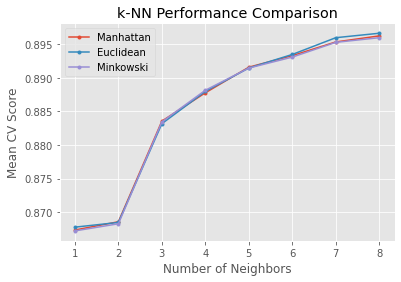

In [87]:

results_KNN = pd.DataFrame(gs_KNN.cv_results_['params'])
results_KNN['test_score'] = gs_KNN.cv_results_['mean_test_score']
results_KNN['metric'] = results_KNN['p'].replace([1,2,5], ["Manhattan", "Euclidean", "Minkowski"])
results_KNN

plt.style.use("ggplot")


for i in ["Manhattan", "Euclidean", "Minkowski"]:
    temp = results_KNN[results_KNN['metric'] == i]
    plt.plot(temp['n_neighbors'], temp['test_score'], marker = '.', label = i)
  
    

plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel("Mean CV Score")
plt.title("k-NN Performance Comparison")
plt.show()

## 2- Random Forest

In [88]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier()

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)

rf_pred=clf.predict(X_test)

In [89]:
print('Accuracy : {}'.format(accuracy_score(y_test,rf_pred)*100))

Accuracy : 89.83844241922121


In [90]:
labels = ['Tree cover', 'Shrubland', 'Grassland', 'Cropland', 'Built-up', 'Bare/sparse vegetation', 'Snow and ice','Permanent water bodies']

print(classification_report(y_test, rf_pred,target_names=labels))


                        precision    recall  f1-score   support

            Tree cover       0.72      0.64      0.68      2895
             Shrubland       0.59      0.53      0.56       770
             Grassland       0.69      0.72      0.70      5412
              Cropland       0.40      0.09      0.15       213
              Built-up       0.78      0.89      0.83      7164
Bare/sparse vegetation       0.65      0.25      0.36       766
          Snow and ice       0.99      0.99      0.99     30980
Permanent water bodies       0.24      0.12      0.17        80

              accuracy                           0.90     48280
             macro avg       0.63      0.53      0.55     48280
          weighted avg       0.90      0.90      0.89     48280



## Random Forest Parameters

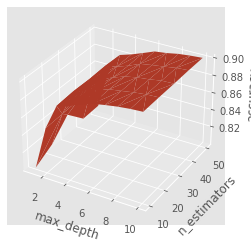

In [91]:
import pandas as pd



max_depth_values = list(range(1, 11))
n_estimatorss=[10,20,30,40,50]

from sklearn import model_selection
results_list = []

for value in max_depth_values:
    for n_estimators in n_estimatorss:
        cv = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)
        rfc=RandomForestClassifier(max_depth=value,n_estimators=n_estimators)
        results = model_selection.cross_val_score(rfc, X,y, cv=cv, scoring='accuracy')
        results_list.append({
            'max_depth': value,
            'n_estimators': n_estimators,
            'mean_accuracy': results.mean()
        })


max_depths = [result['max_depth'] for result in results_list]
n_estimators = [result['n_estimators'] for result in results_list]
mean_accuracies = [result['mean_accuracy'] for result in results_list]
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(max_depths, n_estimators, mean_accuracies)

ax.set_xlabel('max_depth')
ax.set_ylabel('n_estimators')
ax.set_zlabel('accuracy')

plt.show()

### GridSearch

In [92]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [10,20,30,40,50],
  
    'max_depth' :  list(range(1, 10)),
   
}



grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=cv)

grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))


grid_search.best_params_

Best score: 0.9009300185307783
Best parameters: {'max_depth': 9, 'n_estimators': 50}


{'max_depth': 9, 'n_estimators': 50}

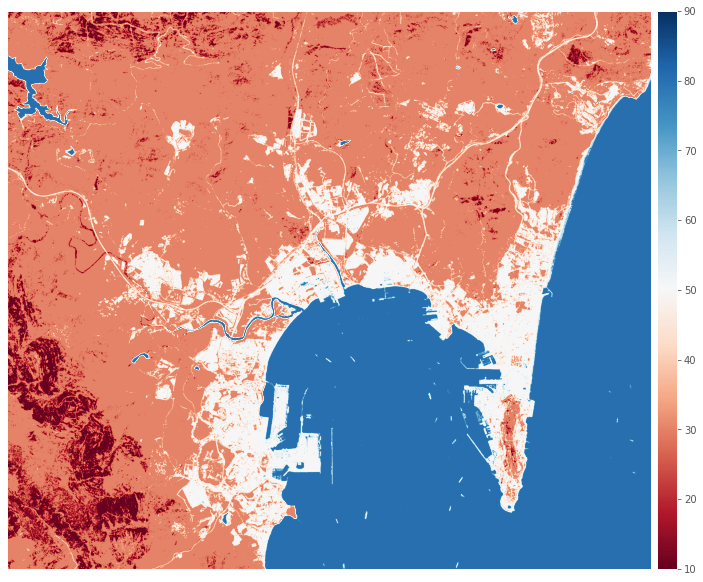

<Axes: >

In [112]:
rf_grid_pred = grid_search.predict(test)
ep.plot_bands(rf_grid_pred.reshape(2309, 2001).T,cmap="RdBu")